In [98]:
library(CausalImpact)
library(ggplot2)
library(missForest)
library(zoo)
library(gridExtra)
t <- seq.Date(as.Date("1984-07-01"), by = "years", length.out = 30)

### Read Data

In [4]:
require("reticulate")
source_python("pickle_reader.py")

# Pixels where there was a significant change in land cover in 1994
ndvi_1994_mean <- read_pickle_file("../../working/ndvi_changed_mean_1994")

### Implement causal analyses on every NDVI trend in disturbed pixels

In [ ]:
set.seed(123)
res=matrix(,nrow=length(ndvi_1994_data),ncol=5)
res2=matrix(,nrow=length(ndvi_1994_data),ncol=5)
y=matrix(NA,nrow=30,ncol=length(ndvi_1994_data))
X=matrix(NA,nrow=30,ncol=length(ndvi_1994_data))

for(k in 1:length(ndvi_1994_data)){
# for(k in 1:5){
    print(k)
    flush.console()
    tryCatch({
        data=ndvi_1994_data[k]
        data<-matrix(unlist(data),nrow=30)
        # all_columns_na <- apply(data, 1, function(row) all(is.na(row)))
        # t_na_rm = t[all_columns_na==FALSE]
        # data_na_rm = data[all_columns_na==FALSE,]
        imputed_data<-missForest(data)
        imputed_data<-imputed_data[1]$ximp

        # data_ts <- zoo(imputed_data, t)
        # ave = rowMeans(data_ts[,2:dim(data_ts)[2]],1)
        y[,k] <- imputed_data[,1]
        X[,k] = rowMeans(imputed_data[,2:dim(imputed_data)[2]],1)
        data_ts_ave = zoo(cbind(y[,k],X[,k]),t)
        pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
        post.period <- as.Date(c("1994-07-01", "2013-07-01"))
        impact <- CausalImpact(data_ts_ave, pre.period, post.period)
        # impact2 <- CausalImpact(data_ts, pre.period, post.period)

        res[k,1] = impact$summary$Actual[1]
        res[k,2] = impact$summary$Pred[1]
        res[k,3] = impact$summary$AbsEffect[1]
        res[k,4] = impact$summary$RelEffect[1]
        res[k,5] = impact$summary$p[1]},
        
    error=function(err){return(NA)})
}

Take the mean of all NDVI in disturbed pixels (y) and not-disturnbed pixels (X)

In [ ]:
y_mean = rowMeans(y,na.rm=TRUE)
X_mean = rowMeans(X,na.rm=TRUE)
data_mean = zoo(cbind(y_mean,X_mean),t)
save(res, data_mean, file = "../working/ci_results_data.RData")

In [18]:
load("../../working/ci_results_data.RData")

Posterior inference {CausalImpact}

                         Average           Cumulative     
Actual                   0.56              11.24          
Prediction (s.d.)        0.59 (0.0047)     11.83 (0.0934) 
95% CI                   [0.58, 0.6]       [11.65, 12.0]  
                                                          
Absolute effect (s.d.)   -0.03 (0.0047)    -0.59 (0.0934) 
95% CI                   [-0.039, -0.02]   [-0.780, -0.41]
                                                          
Relative effect (s.d.)   -5% (0.75%)       -5% (0.75%)    
95% CI                   [-6.5%, -3.5%]    [-6.5%, -3.5%] 

Posterior tail-area probability p:   0.00101
Posterior prob. of a causal effect:  99.89889%

For more details, type: summary(impact, "report")

NULL


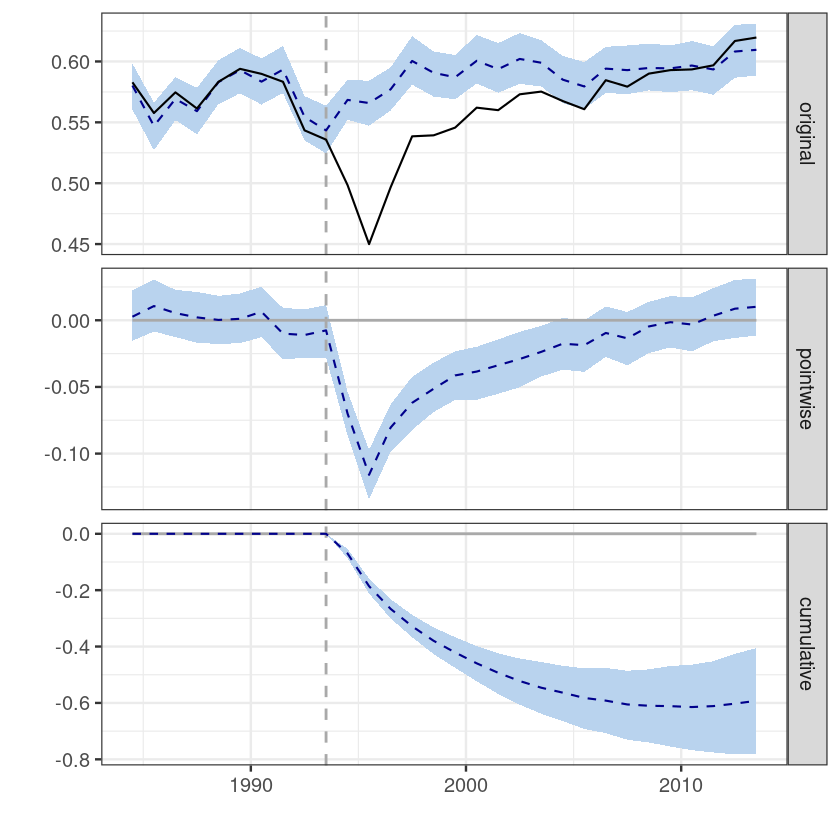

In [24]:
set.seed(1)
pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
post.period <- as.Date(c("1994-07-01", "2013-07-01"))
ci <- CausalImpact(data_mean, pre.period, post.period)
plot(ci)
print(summary(ci))

In [58]:
infer <- ci$series
infer[1,]

            response cum.response point.pred point.pred.lower point.pred.upper
1984-07-01 0.5828943    0.5828943  0.5802414        0.5604114         0.598301
            cum.pred cum.pred.lower cum.pred.upper point.effect
1984-07-01 0.5828943      0.5828943      0.5828943    0.0026529
           point.effect.lower point.effect.upper cum.effect cum.effect.lower
1984-07-01        -0.01540669         0.02248289          0                0
           cum.effect.upper
1984-07-01                0

In [134]:
pred <- infer$point.pred
response <- infer$response
pred.lower <- infer$point.pred.lower
pred.upper <- infer$point.pred.upper
data = data.frame(pred,pred.lower,pred.upper)

Don't know how to automatically pick scale for object of type <zoo>. Defaulting
to continuous.


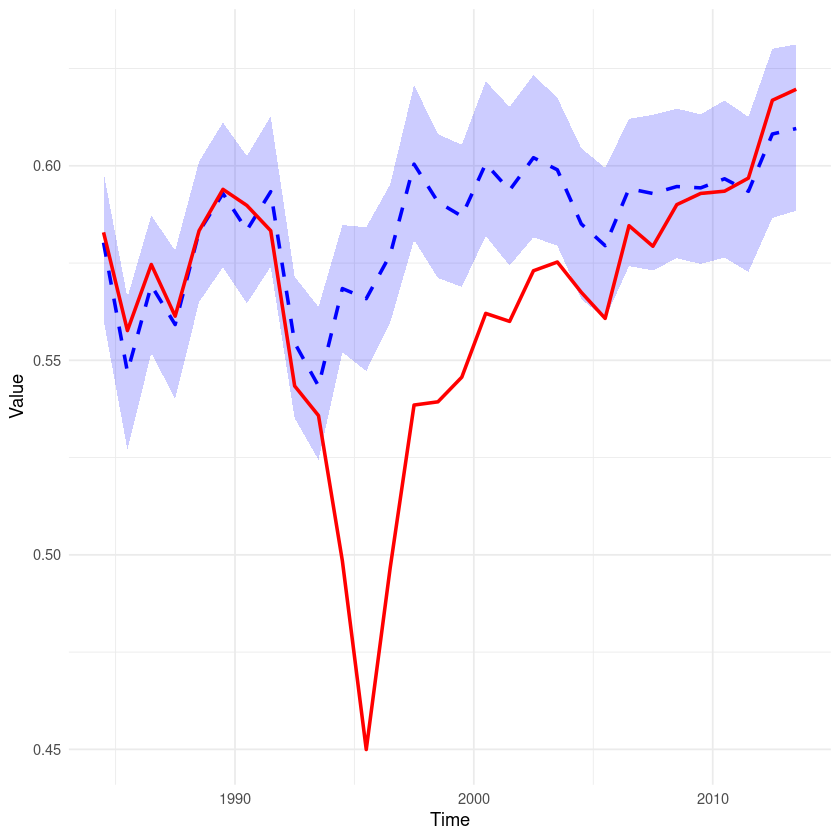

In [141]:
gg <- ggplot() +
  geom_line(aes(x=t,y = pred), color = "blue", size = 1,linetype="dashed") +
  geom_ribbon(aes(t,ymin=pred.lower,ymax=pred.upper),fill="blue",alpha=0.2)+
  geom_line(aes(x=t,y = response), color = "red", size = 1) +
  labs(
    x = "Time",
    y = "Value"
  ) + theme_minimal()
gg
  # gg2 <- ggplot(aes(x = t)) +
  # geom_line(aes(y = response), color = "blue", size = 1) +
  # geom_line(aes(y = pred), color = "red", size = 1) +
  # labs(
  #   x = "Time",
  #   y = "Value"
  # ) + theme_minimal()
# combined_plot <- grid.arrange(gg1, gg2, nrow = 2)
# combined_plot

Posterior inference {CausalImpact}

                         Average            Cumulative      
Actual                   0.58               11.67           
Prediction (s.d.)        0.59 (0.0055)      11.82 (0.1097)  
95% CI                   [0.58, 0.6]        [11.60, 12.0]   
                                                            
Absolute effect (s.d.)   -0.0071 (0.0055)   -0.1424 (0.1097)
95% CI                   [-0.018, 0.0035]   [-0.361, 0.0706]
                                                            
Relative effect (s.d.)   -1.2% (0.92%)      -1.2% (0.92%)   
95% CI                   [-3%, 0.61%]       [-3%, 0.61%]    

Posterior tail-area probability p:   0.092
Posterior prob. of a causal effect:  91%

For more details, type: summary(impact, "report")

NULL


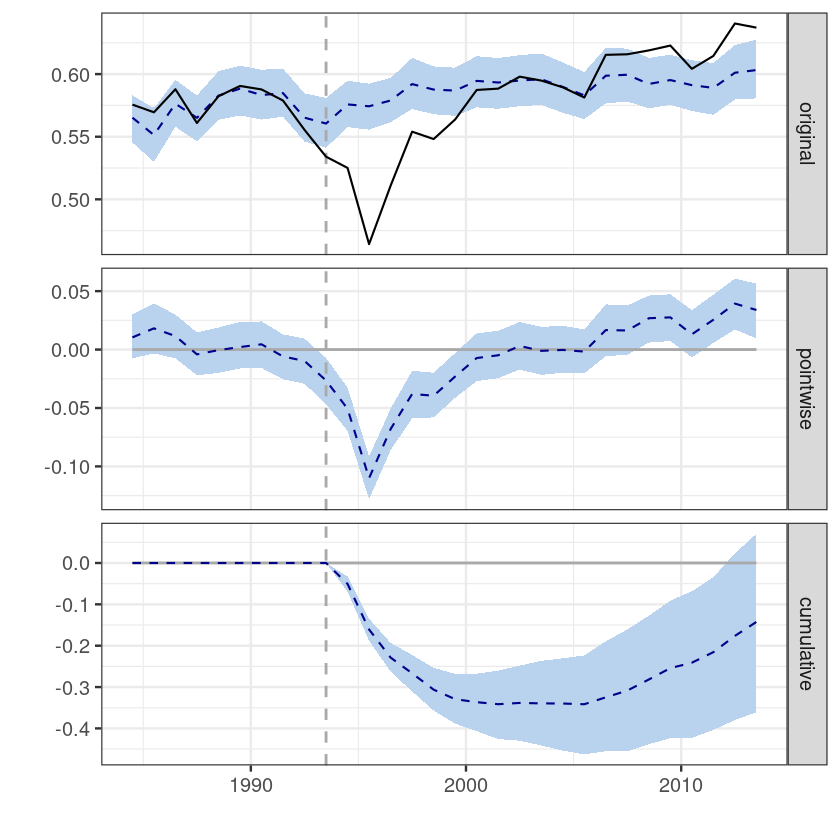

In [8]:
set.seed(15)
t <- seq.Date(as.Date("1984-07-01"), by = "years", length.out = 30)
data <- zoo(ndvi_1994_mean, t)
pre.period <- as.Date(c("1984-07-01", "1993-07-01"))
post.period <- as.Date(c("1994-07-01", "2013-07-01"))
impact <- CausalImpact(data, pre.period, post.period)
plot(impact)
print(summary(impact))

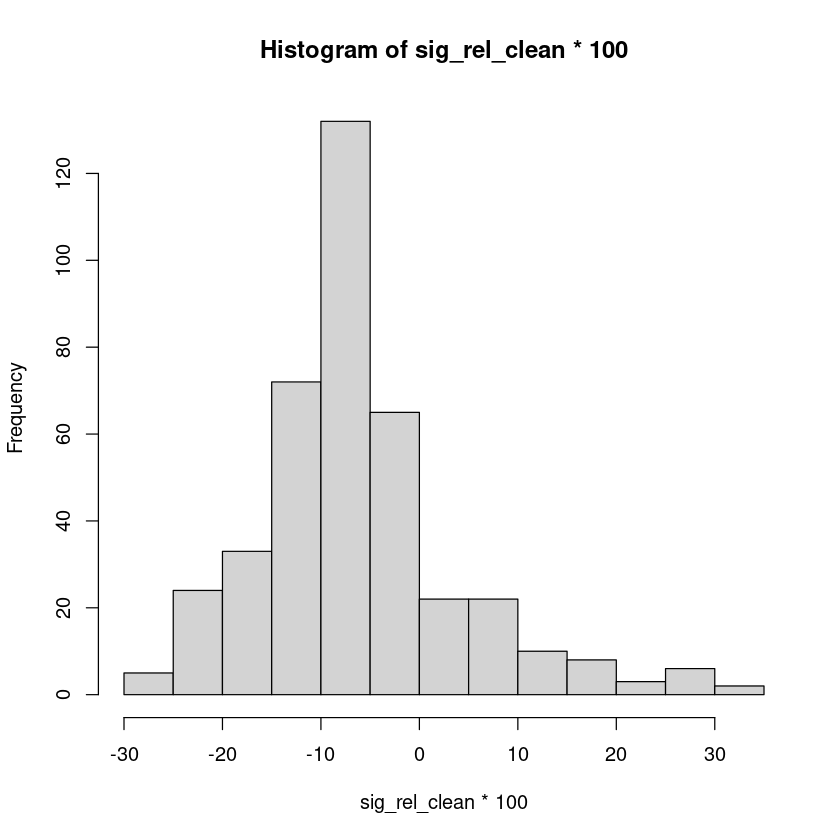

In [22]:
zscore <- function(data,std){
    (abs(data-mean(data))/sd(data))
}
res_na <- apply(res, 1, function(row) all(is.na(row)))
res_no_nan =res[res_na==FALSE,] 
sig = res_no_nan[,5]<0.01
sig_rel = res_no_nan[sig,4]
sig_rel_clean = sig_rel[(zscore(sig_rel)<3)]
hist(sig_rel_clean*100)